In [7]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

In [8]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [9]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))

model_ = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=6,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

# load the model checkpoint
with torch.no_grad():
    model_.load_state_dict(torch.load('keypointsrcnn_weights.pth'))
    model_.to(device)
    model_.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [19]:
import time

image = cv2.imread('/drive0-storage/robot_pose/keypoint_rcnn_training_pytorch/rcnn_robot/train/images/output5_276.jpg')
start_time = time.time()

with torch.no_grad():
    orig_frame = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = torch.tensor(image, dtype=torch.float)
    image = image.unsqueeze(0).to(device)
    outputs = model_(image)
print("--- %s seconds ---" % (time.time() - start_time))
# outputs

--- 1.7416350841522217 seconds ---


In [20]:
# image.shape
torch.onnx.export(model_, image, "keypoint_rcnn.onnx")

/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:5408: UserWarning: Exporting aten::index operator of advanced indexing in opset 14 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


In [23]:
!pip install -r openvino-req.txt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 25.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.5/904.5 kB 63.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 52.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 64.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 35.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.4/706.4 kB 63.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 33.8 MB/s et

In [27]:
# Construct the command for Model Optimizer.
onnx_path= 'keypoint_rcnn.onnx'
mo_command = f"""mo
                 --input_model "{onnx_path}"
                 --compress_to_fp16
                 --output_dir "{'model'}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")

mo_result = %sx $mo_command
print("\n".join(mo_result))
# mo --input_model 'keypoint_rcnn.onnx' --compress_to_fp16 --output_dir 'model'

Model Optimizer command to convert the ONNX model to OpenVINO:
/bin/bash: line 1: mo: command not found


In [41]:
keypoints_classes_ids2names = {0: 'Head', 1: 'Trunk', 2: 'RH', 3: 'LH', 4: 'RF', 5: 'LF'}

def visualize(image, bboxes=None, keypoints=None, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18
    
    if bboxes is not None:
        for bbox in bboxes:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            kp = [int(kp[0]), int(kp[1])]
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), -1)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        if bboxes is not None:
            for bbox in bboxes_original:
                start_point = (bbox[0], bbox[1])
                end_point = (bbox[2], bbox[3])
                image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), -1)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

## 1. ONNX Model in OpenVINO Runtime

In [59]:
from openvino.runtime import Core
# Load the network to OpenVINO Runtime.
ie = Core()
model_onnx = ie.read_model(model='model/keypoint_rcnn.onnx')
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

output_layer_onnx = compiled_model_onnx.output(0)

In [65]:
# Run inference on the input image.
start_time = time.time()
res_onnx = compiled_model_onnx([image])
print("--- %s seconds ---" % (time.time() - start_time))
# res_onnx

--- 0.5871856212615967 seconds ---


## 2. OpenVINO IR Model in OpenVINO Runtime

In [22]:
from openvino.runtime import Core
# Load the network in OpenVINO Runtime.
ie = Core()
model_ir = ie.read_model(model='model/keypoint_rcnn.xml')
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get input and output layers.
output_layer_ir = compiled_model_ir.output(0)

In [67]:
# Run inference on the input image.
start_time = time.time()
# res_ir = compiled_model_ir([image])[output_layer_ir]
res_ir = compiled_model_ir([image])
print("--- %s seconds ---" % (time.time() - start_time))
# res_ir = [[[res_ir[0][0], res_ir[0][1]], [res_ir[0][2], res_ir[0][3]],
#           [res_ir[1][0], res_ir[1][1]], [res_ir[1][2], res_ir[1][3]],
#           [res_ir[2][0], res_ir[2][1]], [res_ir[2][2], res_ir[2][3]]]]
# res_ir

--- 0.5816314220428467 seconds ---


In [46]:
boxes_index = compiled_model_ir.output(0)
labels_index = compiled_model_ir.output(1)
scores_index = compiled_model_ir.output(2)
keypoints_index = compiled_model_ir.output(3)
keypoints_scores_index = compiled_model_ir.output(4)

[[[470, 154], [467, 220], [432, 143], [511, 143], [439, 314], [478, 322]]]


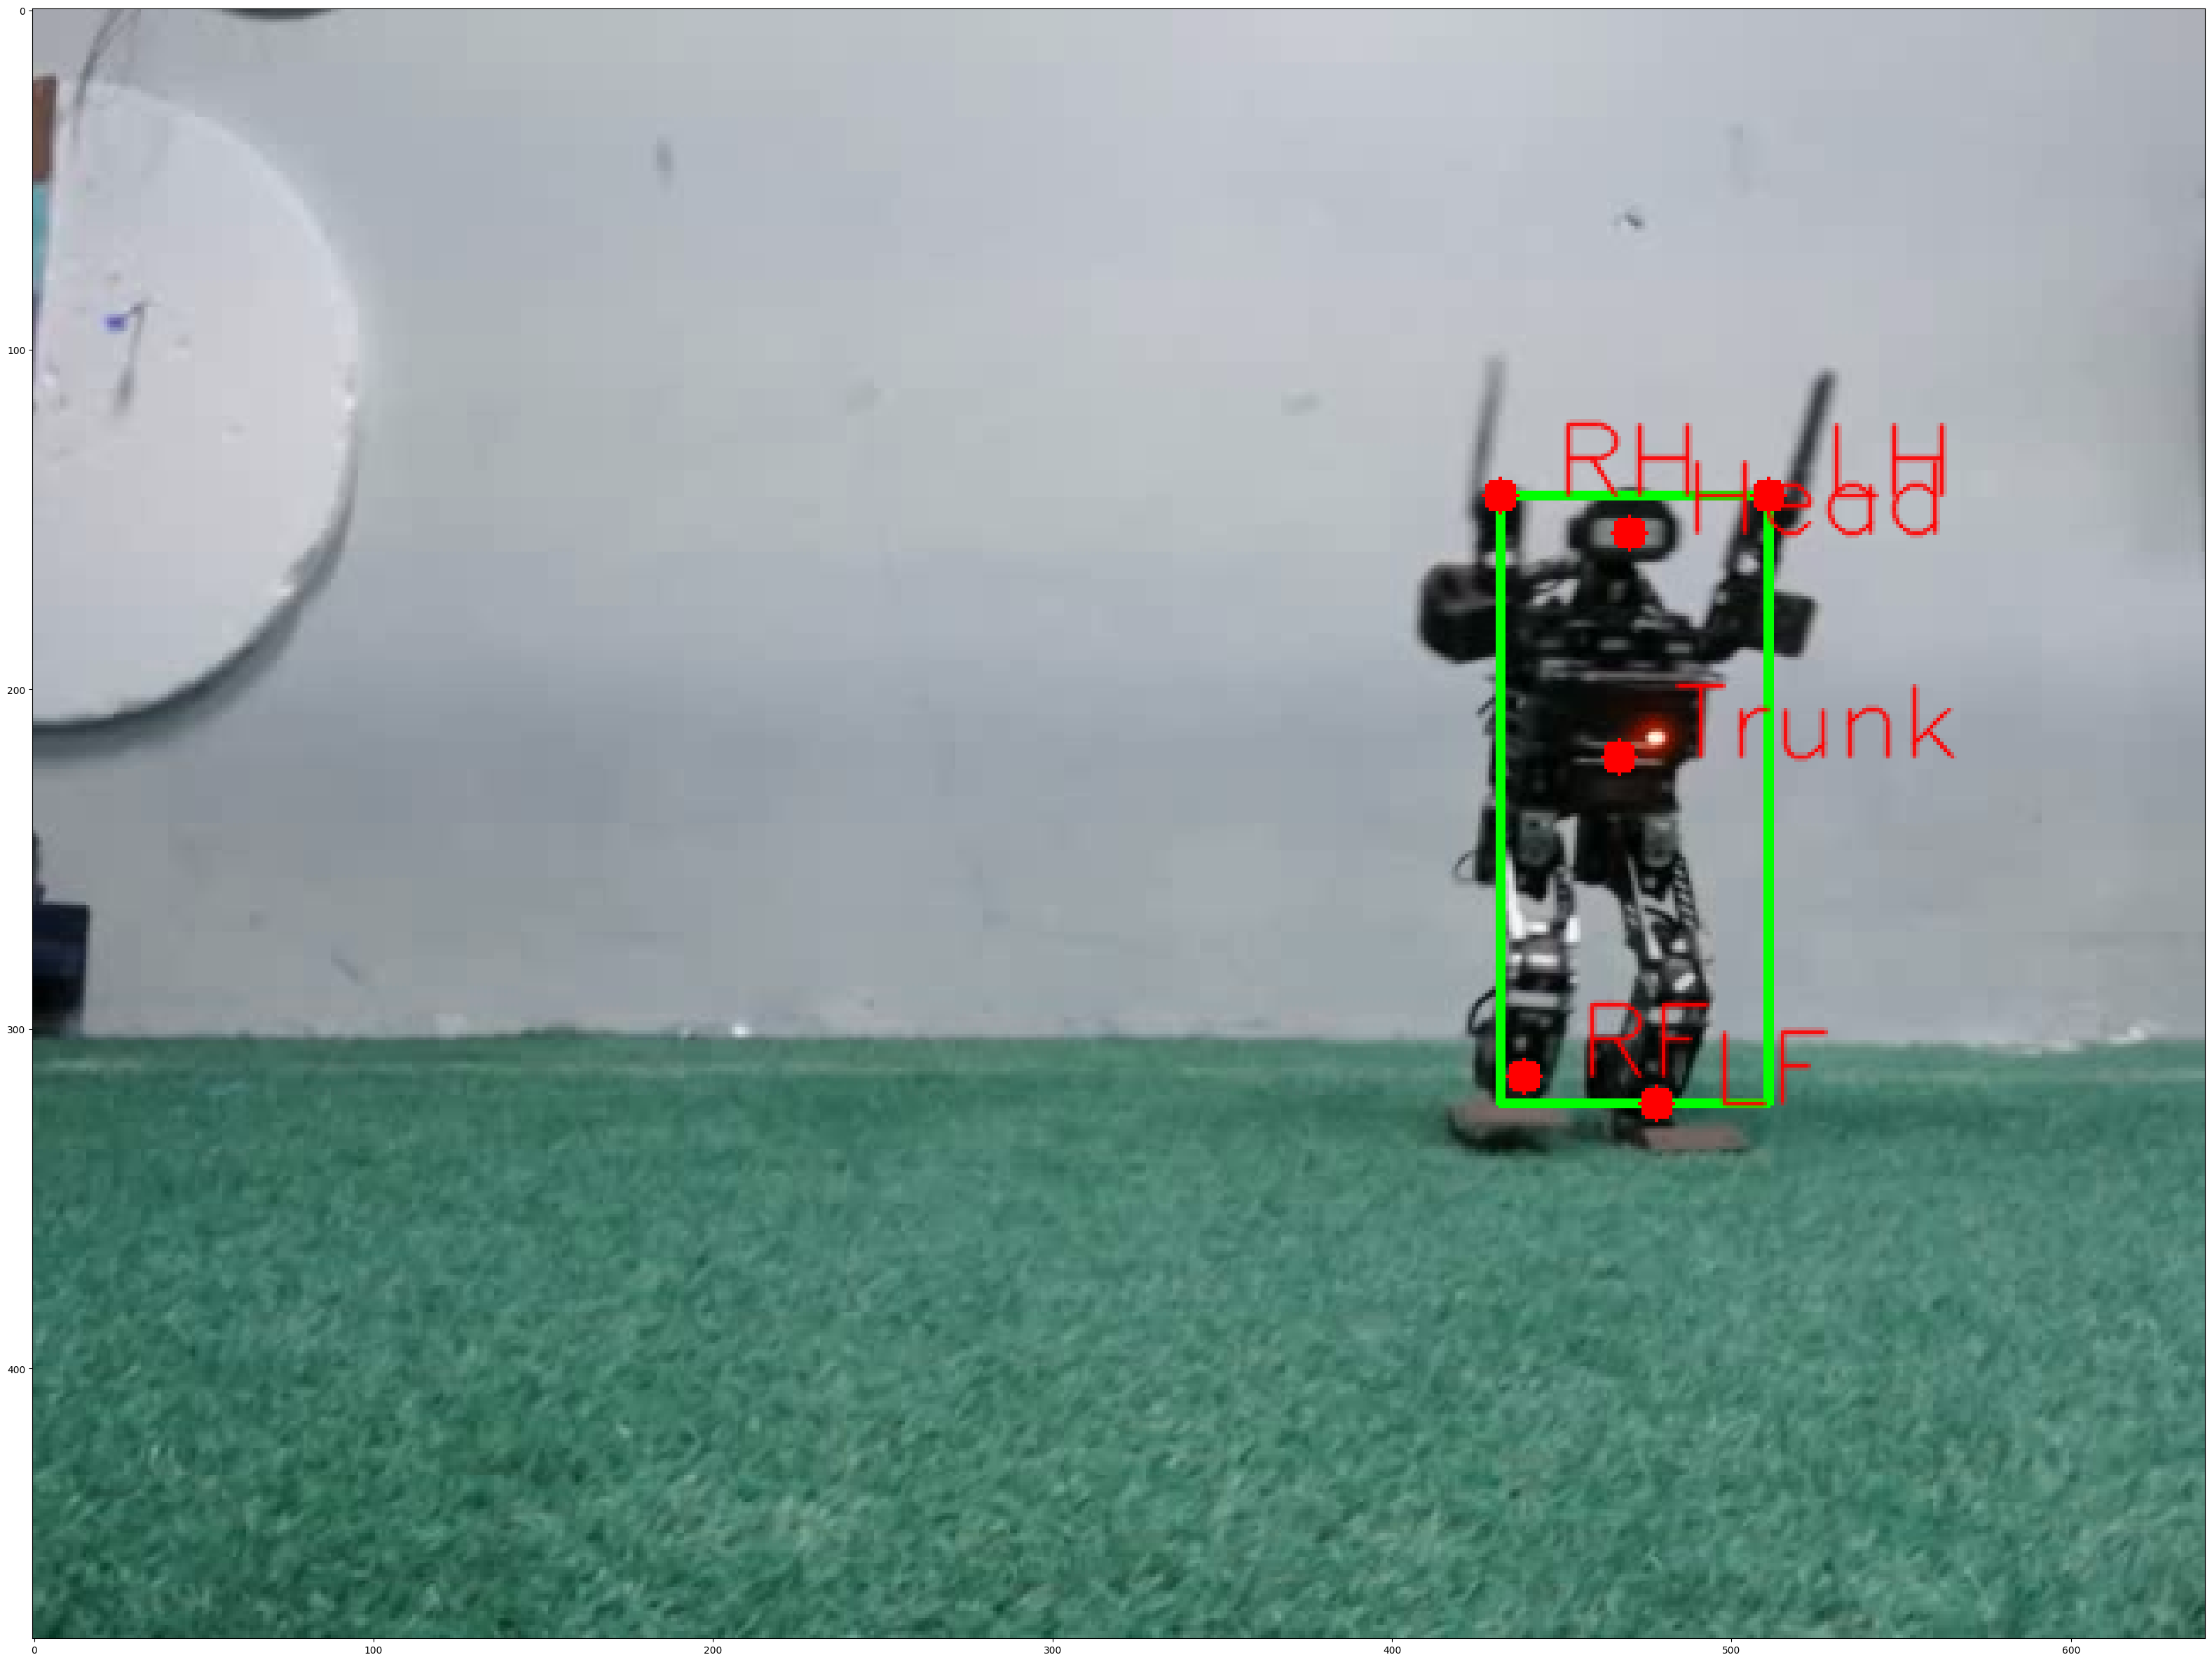

In [57]:
scores = res_ir[scores_index]
high_scores_idxs = np.where(scores > 0.55)[0].tolist() # Indexes of boxes with scores > 0.7

boxes_1 = torch.from_numpy(res_ir[boxes_index])
scores_1 = torch.from_numpy(res_ir[scores_index])
keypoints_1 = torch.from_numpy(res_ir[keypoints_index])

post_nms_idxs = torchvision.ops.nms(boxes_1[high_scores_idxs], scores_1[high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in keypoints_1[high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])
print(keypoints)
bboxes = []
for bbox in boxes_1[high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(orig_frame, bboxes, keypoints)

In [21]:
import onnx
onnx_model = onnx.load("keypoint_rcnn.onnx")
onnx.checker.check_model(onnx_model)

In [22]:
import onnxruntime as ort
import numpy as np
import cv2

# x, y = test_data[0][0], test_data[0][1]
im = cv2.imread('/drive0-storage/robot_pose/keypoint_rcnn_training_pytorch/rcnn_robot/train/images/output5_276.jpg')
# print(type(im))

ort_sess = ort.InferenceSession('keypoint_rcnn.onnx')
outputs = ort_sess.run(None, {'input': image})
outputs
# Print Result 
# predicted, actual = classes[outputs[0][0].argmax(0)], classes[y]
# print(f'Predicted: "{predicted}", Actual: "{actual}"')


<class 'numpy.ndarray'>


2023-04-04 09:52:01.529496851 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 369697, index: 0, mask: {1, 129, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-04-04 09:52:01.529589766 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 369700, index: 3, mask: {4, 132, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-04-04 09:52:01.529619874 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 369701, index: 4, mask: {5, 133, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-04-04 09:52:01.529792841 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 369698, index: 1, mask: {2, 130, }, error code: 22 error msg: Invalid argumen

RuntimeError: Input must be a list of dictionaries or a single numpy array for input 'input'.

dex: 37, mask: {38, 166, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-04-04 09:52:01.584961148 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 369799, index: 102, mask: {103, 231, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-04-04 09:52:01.588674526 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 369795, index: 98, mask: {99, 227, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-04-04 09:52:01.588675448 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 369739, index: 42, mask: {43, 171, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-04-04 09:52:01.588684896 [E:onnxruntime:De